In [31]:
# Import packages
from pymongo import MongoClient
import pandas as pd
from karateclub import Diff2Vec
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import faiss
import seaborn as sns

In [32]:
# Connect to db collections
client = MongoClient('mongodb://localhost:27017/')
db = client['address-clustering']
transfers = db['transfers']
transactions = db['transactions']

# Get addresses active on Ethereum and Polygon as a list
users = pd.read_csv('../data/subsets.csv')
user_addresses = list(set(users.loc[users['Polygon'] == 1, 'Address']).union(users.loc[users['Ethereum'] == 1, 'Address']))
user_addresses

['0x6a2338f756775ae6c9e1abc3db81a21e28a63caa',
 '0x315b9077300ae35efab6c156c071bebbaedd7ddc',
 '0x223aaca0f1f8448240ddcb56581361a14f41a5ef',
 '0x48543ce8f5aa45b3e9aca1488a6c73b3d64f026d',
 '0x819819fe3732b475072aa090b3629546eea0bba6',
 '0x9d081ed5f13a67c80e15873212b9642660639259',
 '0xe191832f3c3dec0519230e065724147d1643104f',
 '0xfe94e5a51d8f79bc16518f58c51ec11ec7890b20',
 '0x1a1509fa10bb505d163c59f9dcf11a4634850c94',
 '0x264a3dc777f0839242e4ffcb19a87dd4c363d1c2',
 '0x24849f60c16beecaaa8efaa7c1a8b850c11221ae',
 '0x432bf249f808f0387e3f4a4fe80287caef2ca45e',
 '0x43fc553f12c519cd53b3396d8ec0bccfe7cf175c',
 '0x82ee9f07eb3c605a41367d34e9830fd033a5c170',
 '0x92c764cb59b45d952ac48da872c549f8933dbb4a',
 '0x6aa800e8460478fc8f13346b47fa0685d4b0d78b',
 '0x985088951903e600b679d35da1ae410c8e4ca87c',
 '0x08099b446ad1d3d2e55fbd287a0acda300fab2db',
 '0x9777daabf322d38af7a49a66dc55f3086127baea',
 '0xaf7c891995f69822fdb5e97225d3920ad58d464a',
 '0x2c9e81d79cf5690bf05752815a97f63fae9819e6',
 '0x15333b6ae

In [33]:
# Function to prepare dataframe to construct graph
def prepare_dataframe(df):
    # Remove self-transfers
    df = df[df['from'] != df['to']]
    # Only keep from and to columns
    df = df[['from', 'to']]
    # Sort from and to addresses lexicographically
    df['from'], df['to'] = np.where(df['from'] > df['to'], [df['to'], df['from']], [df['from'], df['to']])
    # Group by 'from' and 'to', and count the number of interactions
    grouped_df = df.groupby(['from', 'to']).size().reset_index(name='interactions')
    # Only keep rows where weight is greater than 1
    grouped_df = grouped_df[grouped_df['interactions'] > 1]

    return grouped_df

## Construct intra-set transfer and transaction dataframes

In [ ]:
query_conditions = {
    "from": {"$in": user_addresses},
    "to": {"$in": user_addresses}
}

transfer_df = pd.DataFrame(list(transfers.find(query_conditions)))
transfer_df = transfer_df.drop(['_id', 'isSet', 'userAddress'], axis=1).drop_duplicates()
transfer_df

## Prepare dataframe to create network graph

In [12]:
graph_df = prepare_dataframe(transfer_df)
graph_df

# # Count unique addresses
# unique_addresses = pd.concat([graph_df['from'], graph_df['to']]).nunique()
# print(f"Number of unique addresses: {unique_addresses}")

,from,to,interactions
2,0x0000007c60fab7a70c2ae0ebe437f3726b05e7eb,0x765e152063e6f7dd3077980192d0564e93f126b8,2
3,0x000000ff104866d60ed07d3a5f5be7731777831e,0x765e152063e6f7dd3077980192d0564e93f126b8,5
4,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x03ba161f99e0561adc546644640ba6d5602d86c8,2
5,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x0749d1abb5ca9128432b612644c0ea1e9c6cc9af,2
6,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x09bc69a986e1b37fb01ef36124f4c2e14fa0ab6b,2
...,...,...,...
234205,0xfe705ead02e849e78278c50de3d939be23448f1a,0xfefb65dfd2bcb24269b944e34388f6748e38a6a8,21
234206,0xfe9119cc2cdbcd5e456b5758610e0506c91b8339,0xfe97bb8f353b835557792dae13a1eda509866301,3
234207,0xfec33a90737254dcf9aa33188a11f32797197f93,0xff1a9252def51ede4489c05998f5e7cf8ad2c1b3,2
234208,0xff2f7dd3d122237d5b824f79c8300bfb6c5100cf,0xffd3c4424c2cbdb1776572c4d136f15be66890af,3


### Try network visualization

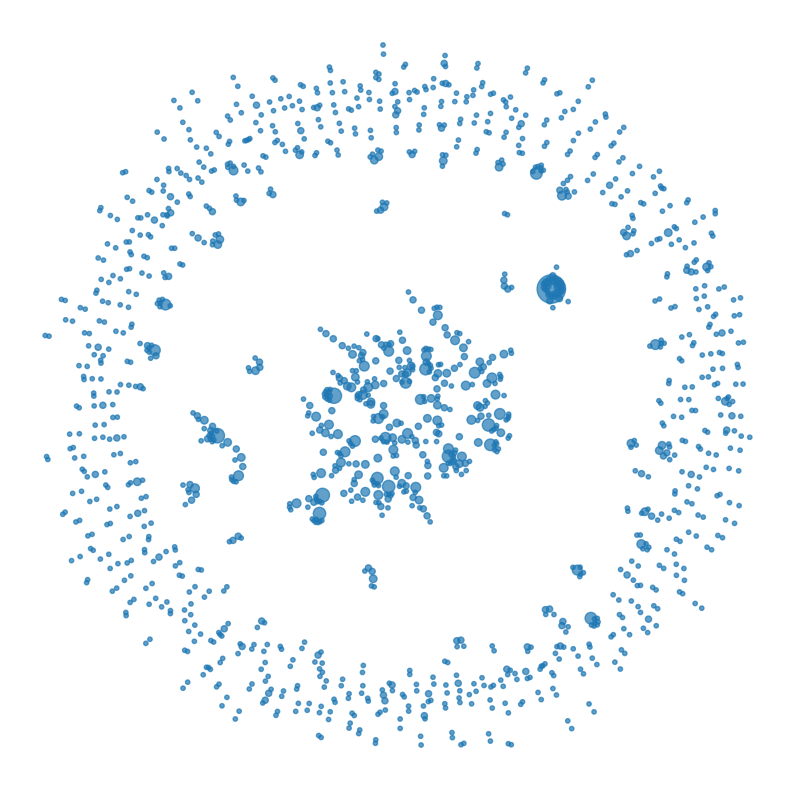

In [13]:
df = graph_df.sample(n=1000)

# Create a graph from the dataframe
G = nx.from_pandas_edgelist(df, 'from', 'to')

# calculate degree for each node and use it as the node size in the plot
degree = nx.degree(G)
node_sizes = [v * 10 for v in dict(degree).values()]

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7)
# nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='grey', width=0.5)

plt.axis('off')
plt.show()

In [14]:
G = nx.from_pandas_edgelist(graph_df, 'from', 'to', 'interactions', create_using=nx.Graph())

# Get the largest connected component (assuming your graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
print(len(largest_cc))

# Create a subgraph of G consisting only of the nodes in the largest connected component
G_cc = G.subgraph(largest_cc)

# Creating a mapping of old node IDs to new node IDs
node_mapping = {node: i for i, node in enumerate(G_cc.nodes)}
# Relabeling the nodes in the graph according to the mapping
G_cc = nx.relabel_nodes(G_cc, node_mapping)

# Initialize Diff2Vec model
model = Diff2Vec(diffusion_number=10, diffusion_cover=10, dimensions=128)

# Fit model to your graph
model.fit(G_cc)

# Get the embeddings
embeddings = model.get_embedding()
embeddings

27842


array([[-0.00644407,  0.13847607, -0.24042043, ...,  0.10617244,
        -0.25198248,  0.17258172],
       [-0.67991596,  0.72040766,  0.36532727, ..., -0.64589596,
        -1.2746363 ,  0.11783767],
       [-0.07014968, -0.04484578,  0.03163753, ...,  0.1672874 ,
         0.00346587, -0.10801727],
       ...,
       [ 0.351755  ,  0.22894861,  0.20295174, ...,  0.12768248,
        -0.02872135, -0.31234834],
       [-0.0415349 ,  0.08799298,  0.6710048 , ...,  0.15797877,
         0.49619976,  0.00303728],
       [-0.17644502,  0.04578217,  0.04416937, ...,  0.1675134 ,
         0.02316064, -0.08372797]], dtype=float32)

In [15]:
# Assuming `embeddings` is a 2D numpy array where each row is the embedding of a node
# Normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Build the index
index = faiss.IndexFlatL2(embeddings.shape[1])

# Add vectors to the index
index.add(embeddings)

# Now, you can query the index for the nearest neighbors of any embedding
# For example, to get the k nearest neighbors for the first embedding
D, I = index.search(embeddings[0:1], k=5)

# D and I are the distances and indices of the nearest neighbors, respectively
print(D)  # Distance to nearest neighbors
print(I)  # Indices of nearest neighbors


[[0.         0.68901205 0.71071756 0.73996985 0.75822407]]
[[    0 23132 12226 13681 11942]]


In [16]:
# Number of nearest neighbours to consider
k = 5

# This will store the clusters. Each cluster is a set of nodes (i.e., a set of indices).
clusters = []

threshold = 0.5

# Iterate over all embeddings
for i in range(embeddings.shape[0]):
    # Query the index for the k nearest neighbors of the i-th embedding
    D, I = index.search(embeddings[i:i+1], k)

    # The indices of the nearest neighbors of the i-th node are in I[0]
    neighbours = set(I[0][D[0] < threshold])

    # Check if the node is already part of a cluster
    for cluster in clusters:
        if i in cluster:
            # If the node is part of a cluster, we extend this cluster by the new neighbours
            cluster.update(neighbours)
            break
    else:
        # If the node was not part of any cluster, we create a new cluster
        clusters.append(neighbours)


print(len(clusters))
clusters
# 26,740

[{0},
 {1},
 {2},
 {3},
 {4},
 {5},
 {6},
 {7},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19},
 {20},
 {21},
 {22},
 {23},
 {24},
 {25},
 {26},
 {27},
 {28},
 {29},
 {30},
 {31},
 {32},
 {33},
 {34},
 {35},
 {36},
 {37},
 {38},
 {39},
 {40},
 {41},
 {42},
 {43},
 {44},
 {45},
 {46},
 {47},
 {48},
 {49},
 {50},
 {51},
 {52},
 {53},
 {54},
 {55},
 {56},
 {57},
 {58},
 {59},
 {60},
 {61},
 {62},
 {63},
 {64},
 {65},
 {66},
 {67},
 {68},
 {69},
 {70},
 {71},
 {72, 73},
 {74},
 {75},
 {76},
 {77},
 {78},
 {79},
 {80},
 {81},
 {82},
 {83, 6724, 25305, 26346},
 {84},
 {85},
 {86},
 {87},
 {88},
 {89},
 {90},
 {91},
 {92},
 {93},
 {94},
 {95},
 {96},
 {97},
 {98},
 {99},
 {100, 13045, 13046, 13047, 13048},
 {101},
 {102},
 {103},
 {104},
 {105},
 {106},
 {107},
 {108},
 {109},
 {110},
 {111},
 {112},
 {113},
 {114},
 {115},
 {116},
 {117},
 {118},
 {119},
 {120},
 {121, 6733, 10870, 15489, 18813, 25097, 26616},
 {122, 1071, 18399, 18400},
 {123},
 {124, 27743

In [23]:
# Create an inverse mapping
inverse_node_mapping = {i: node for node, i in node_mapping.items()}

# Now, let's say you have a list of node IDs you got from FAISS,
# and you want to convert them back to original addresses
faiss_node_ids = [126, 140]  # just an example, replace with your actual node IDs

# Get the original addresses
clustered_addresses = [inverse_node_mapping[node_id] for node_id in faiss_node_ids]

print(clustered_addresses)

['0x000a6b4e3de8d635b177d8ecd99fd19bfa0fb73d', '0x000c0dec0ece1aa126a17b5925d71819b6c6b021']


In [25]:
df = transfer_df[transfer_df['from'].isin(clustered_addresses)]
df

,_id,timeStamp,hash,from,to,contractAddress,value,nonce,tokenName,gasPrice,gasUsed,chainName,tokenType,tokenID,isSet,userAddress
594,64b3c69ed2daf924bf0e7669,1637654485,0x22bd8965b928760c39fc44e141377e482ac4bba2b10d...,0x000a6b4e3de8d635b177d8ecd99fd19bfa0fb73d,0x000a7cb7ad15c0df396e25e0c4528e8e049dbb08,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,2.724909,2,USD Coin (PoS),30000000000,48528,Polygon,20,,from,0x000a6b4e3de8d635b177d8ecd99fd19bfa0fb73d
595,64b3c69ed2daf924bf0e766a,1637654485,0x22bd8965b928760c39fc44e141377e482ac4bba2b10d...,0x000a6b4e3de8d635b177d8ecd99fd19bfa0fb73d,0x000a7cb7ad15c0df396e25e0c4528e8e049dbb08,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,2.724909,2,USD Coin (PoS),30000000000,48528,Polygon,20,,to,0x000a7cb7ad15c0df396e25e0c4528e8e049dbb08
596,64b3c7e3d2daf924bf0114c9,1640466949,0x8011a95c42d5f8c00f8c9acaf8b2f03f166e81afa80f...,0x000a6b4e3de8d635b177d8ecd99fd19bfa0fb73d,0xa192a9662959a5577fb11de3a7ea91251e7720d6,0xf1483f042614105cb943d3dd67157256cd003028,,4995910,Xmas-2021,201299999997,382348,Polygon,721,2106245833371143733958360553673408646377901908...,from,0x000a6b4e3de8d635b177d8ecd99fd19bfa0fb73d
597,64b3c7e3d2daf924bf0114ca,1640466949,0x8011a95c42d5f8c00f8c9acaf8b2f03f166e81afa80f...,0x000a6b4e3de8d635b177d8ecd99fd19bfa0fb73d,0xa192a9662959a5577fb11de3a7ea91251e7720d6,0xf1483f042614105cb943d3dd67157256cd003028,,4995910,Xmas-2021,201299999997,382348,Polygon,721,2106245833371143733958360553673408646377901908...,to,0xa192a9662959a5577fb11de3a7ea91251e7720d6
638,64b3c69ed2daf924bf0e770a,1637758412,0x4cb6cd028e1535586e2f44180963ad6b6dbbc76276b0...,0x000c0dec0ece1aa126a17b5925d71819b6c6b021,0x000c12048f241bc7f652188219de1320cde6c849,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,1.92015,2,USD Coin (PoS),30000000000,48528,Polygon,20,,to,0x000c12048f241bc7f652188219de1320cde6c849
639,64b3c69ed2daf924bf0e770b,1637758412,0x4cb6cd028e1535586e2f44180963ad6b6dbbc76276b0...,0x000c0dec0ece1aa126a17b5925d71819b6c6b021,0x000c12048f241bc7f652188219de1320cde6c849,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,1.92015,2,USD Coin (PoS),30000000000,48528,Polygon,20,,from,0x000c0dec0ece1aa126a17b5925d71819b6c6b021
640,64b3c7e3d2daf924bf011dbe,1640455990,0x849be24bc5ebd08471cc15047040ddbff63039f233ee...,0x000c0dec0ece1aa126a17b5925d71819b6c6b021,0xa192a9662959a5577fb11de3a7ea91251e7720d6,0xf1483f042614105cb943d3dd67157256cd003028,,4984906,Xmas-2021,180000000000,382348,Polygon,721,2106245833371143733958360553673408646377901908...,from,0x000c0dec0ece1aa126a17b5925d71819b6c6b021
641,64b3c7e3d2daf924bf011dbf,1640455990,0x849be24bc5ebd08471cc15047040ddbff63039f233ee...,0x000c0dec0ece1aa126a17b5925d71819b6c6b021,0xa192a9662959a5577fb11de3a7ea91251e7720d6,0xf1483f042614105cb943d3dd67157256cd003028,,4984906,Xmas-2021,180000000000,382348,Polygon,721,2106245833371143733958360553673408646377901908...,to,0xa192a9662959a5577fb11de3a7ea91251e7720d6


In [26]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')  # Convert UNIX timestamps to datetime
df['hour_of_day'] = df['timeStamp'].dt.hour + df['timeStamp'].dt.minute/60  # Extract the time of the day in hours

/var/folders/6y/q2mh3ct92xx9v05c53h84l6c0000gn/T/ipykernel_42126/3726759338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')  # Convert UNIX timestamps to datetime
/var/folders/6y/q2mh3ct92xx9v05c53h84l6c0000gn/T/ipykernel_42126/3726759338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_of_day'] = df['timeStamp'].dt.hour + df['timeStamp'].dt.minute/60  # Extract the time of the day in hours


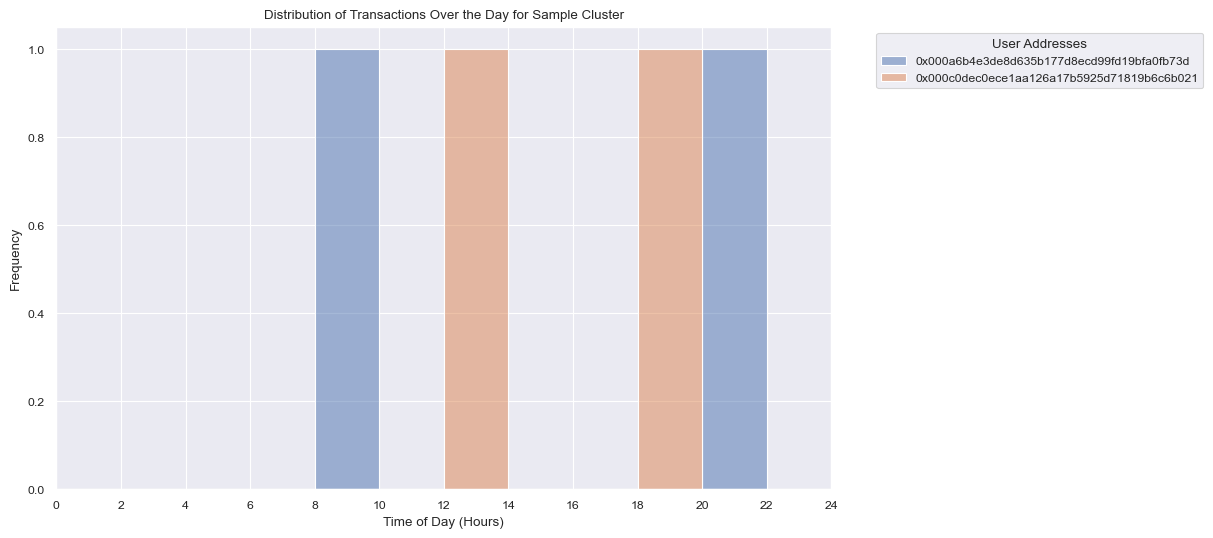

In [30]:
# Create a list of unique addresses
addresses = df['from'].unique()

# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(addresses)))

plt.figure(figsize=[10,6])

bins = np.linspace(0, 24, num=13)

# Plot histogram for each user address
for address in addresses:
    subset = df[df['userAddress'] == address]
    sns.histplot(subset['hour_of_day'], bins=bins, label=address, alpha=0.5)

sns.set_theme(context='paper')
plt.xlabel('Time of Day (Hours)')
plt.xticks(bins)
plt.ylabel('Frequency')
plt.xlim((0,24))
plt.title('Distribution of Transactions Over the Day for Sample Cluster')
plt.legend(title='User Addresses', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside of plot
plt.show()

### Use transactions

In [ ]:
# Query native asset transactions where both 'from' and 'to' are in the list of users
query_conditions = {
    "input" : '0x',
    "from": {"$in": users},
    "to": {"$in": users}
}

transaction_df = pd.DataFrame(list(transactions.find(query_conditions)))

cleaned_transactions = prepare_dataframe(transaction_df, ['_id'])
cleaned_transactions